In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score, log_loss, roc_auc_score
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

### Procesamiento de texto

In [2]:
def procesar_texto(text):
    '''
    1. El texto se pasa todo a minúsculas
    2. Se eliminan todos los símbolos que pueden dar problemas
    3. Se tokeniza el texto
    4. Se eliminan las stop_words, básicamente preposiciones o palabras que no aportan contenido semántico, a excepción de las negaciones porque pueden dar información conrextual relevante.
    5. Se convierten los tokens mediantes stemming, que se queda con la raiz o "lema" de una palabra para mejorar el rendimiento
    '''
    text = text.lower() 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}
    tokens = [token for token in tokens if token not in stop_words]

    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def text_to_embedding(tokens, embeddings_index, embedding_dim=100):
    '''
    1. Se inicializa el embedding (vector) vacío pero con las dimensiones especificadas (100, que coincide con las dimensiones de los embeddings descargados)
    Este vector guarda el sumatorio acumulado de cada embedding individual de cada palabra (de 100 dimensiones también), que representará el texto completo.
    2. Se inicia un conteo a 0, este conteo servirá para contar cuantos embeddings válidos encontramos en el índice, y si no hay se mantiene a 0 para prevenir errores futuros al dividir.
    3. Se itera sobre la lista de tokens del texto y si se encuentra el token en el índice de embeddings, se añade el vector de la palabra al vector de embedding. Cada vez que encuentra una válido se suma 1 al conteo.
    4. Por último se saca la media del embedding con el número de conteo para que las palabras más representadas en un texto no dominen el embedding final.
    '''
    embedding = np.zeros(embedding_dim)
    count = 0
    for token in tokens:
        if token in embeddings_index:
            embedding += embeddings_index[token]
            count += 1
    if count > 0:
        embedding /= count
    return embedding



Se define la puntuación con la que se van a optimizar los modelos en optuna

In [34]:
def validation_score(model, X, y):
    # Dividir el conjunto en entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar el modelo en el conjunto de entrenamiento
    model.fit(X_train, y_train)
    
    # Predecir las probabilidades en el conjunto de validación
    y_val_pred = model.predict(X_val)
    
    # Calcular la métrica F1-Score
    score = f1_score(y_val, y_val_pred, average='binary')
    return score

In [45]:
class MultiHeadHateClassifier:
    def __init__(self):
        self.models = {}
        self.label_columns = ['IsAbusive', 'IsProvocative']
        self.embeddings_index = None

    def optimize_model(self, X, y, column):
        """
        Realiza una búsqueda de hiperparámetros con Optuna para el modelo de una columna específica.
        """
        pos_weight = (y[column] == 0).sum() / (y[column] == 1).sum()

        def objective(trial):
            # Espacio de búsqueda para los hiperparámetros de XGBClassifier
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'gamma': trial.suggest_float('gamma', 1e-6, 1.0, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 10.0, log=True),
                'scale_pos_weight': pos_weight
            }
            
            model = XGBClassifier(**params)
            model.fit(X, y[column])
            
            score = validation_score(model, X, y[column])
            return score

        # Crear el estudio Optuna
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)
        
        # Guardar el mejor modelo en self.models
        best_params = study.best_params
        best_params['scale_pos_weight'] = pos_weight
        best_model = XGBClassifier(**best_params)
        best_model.fit(X, y[column])
        
        return best_model

    def fit(self, X, y):
        for column in self.label_columns:
            print(f"Optimizing model for {column}")
            model = self.optimize_model(X, y, column)
            self.models[column] = model
            
    def predict(self, X):
        predictions = {}
        for column in self.label_columns:
            predictions[column] = self.models[column].predict(X)

        final_prediction = np.any(list(predictions.values()), axis=0)
        return final_prediction, predictions
    
    def load_embeddings(self, file_path):
        self.embeddings_index = {}
        with open(file_path, encoding='utf8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                self.embeddings_index[word] = coefs

    def preprocess_text(self, text):
        tokens = procesar_texto(text)
        embedding = text_to_embedding(tokens, self.embeddings_index, 100)
        return np.array([embedding])

Se quitan aquellas columnas que tienen pocos valores de True para limitar el desbalanceo en las clases

In [46]:
classifier = MultiHeadHateClassifier()
classifier.load_embeddings('../assets/glove.twitter.27B.100d.txt')

df = pd.read_csv('../database/toxic.csv')

# Definimos el umbral
threshold = 0.15

# Seleccionamos las columnas que queremos analizar (todas menos 'Text', 'CommentId', y 'VideoId')
columns_to_check = df.loc[:, ~df.columns.isin(['Text', 'CommentId', 'VideoId'])]

# Filtramos las columnas cuyo promedio sea mayor o igual al umbral
columns_above_threshold = columns_to_check.columns[columns_to_check.mean() >= threshold]

# Seleccionamos todas las columnas que queremos conservar
columns_to_keep = ['Text', 'CommentId', 'VideoId'] + list(columns_above_threshold)

# Filtramos el DataFrame con las columnas que cumplen con los criterios
df_filtered = df[columns_to_keep]

df_filtered = df_filtered.drop(columns = ['CommentId', 'VideoId'])


In [47]:
X = np.array([classifier.preprocess_text(text)[0] for text in df_filtered['Text']])
y = df_filtered.drop(columns = 'Text')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

In [48]:
classifier.fit(X_train, y_train)

# Make predictions
toxic_pred, type_predictions = classifier.predict(X_test)

[I 2024-11-19 13:38:13,410] A new study created in memory with name: no-name-6f8d5819-21f5-49ac-a1d6-141d69536d21


Optimizing model for IsAbusive


[I 2024-11-19 13:38:15,568] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 208, 'learning_rate': 0.00038411999194771124, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.03476719930632426, 'subsample': 0.7815236771923274, 'colsample_bytree': 0.6504378898503171, 'reg_alpha': 0.4982265322118186, 'reg_lambda': 0.00737819364481311}. Best is trial 0 with value: 0.5.
[I 2024-11-19 13:38:17,412] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 365, 'learning_rate': 0.0001246918192564833, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 1.5230510911385882e-06, 'subsample': 0.8319627134188585, 'colsample_bytree': 0.5174430544316831, 'reg_alpha': 0.00019476596768009148, 'reg_lambda': 1.525223257242162e-05}. Best is trial 0 with value: 0.5.
[I 2024-11-19 13:38:18,165] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 111, 'learning_rate': 0.0022990102505714136, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.03924550025103735, 'subsample': 0.7

Optimizing model for IsProvocative


[I 2024-11-19 13:39:55,080] Trial 0 finished with value: 0.14814814814814814 and parameters: {'n_estimators': 347, 'learning_rate': 0.02120421141840074, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.13013294231185474, 'subsample': 0.949411456493013, 'colsample_bytree': 0.6990111559753982, 'reg_alpha': 2.76182668364992e-05, 'reg_lambda': 5.533636596214808}. Best is trial 0 with value: 0.14814814814814814.
[I 2024-11-19 13:39:57,575] Trial 1 finished with value: 0.24 and parameters: {'n_estimators': 238, 'learning_rate': 0.03701698681917015, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 1.1585341147205562e-05, 'subsample': 0.5340248458323267, 'colsample_bytree': 0.8780442005724776, 'reg_alpha': 0.0065602916293557405, 'reg_lambda': 2.7209508723258513}. Best is trial 1 with value: 0.24.
[I 2024-11-19 13:40:01,796] Trial 2 finished with value: 0.26666666666666666 and parameters: {'n_estimators': 422, 'learning_rate': 0.02518778674437731, 'max_depth': 7, 'min_child_weight': 2, 'gamma'

Accuracy: 0.72
Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.82      0.76       166
        True       0.73      0.60      0.66       134

    accuracy                           0.72       300
   macro avg       0.72      0.71      0.71       300
weighted avg       0.72      0.72      0.72       300



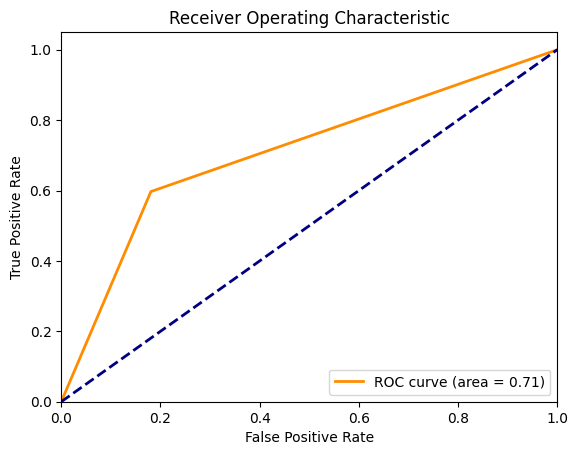

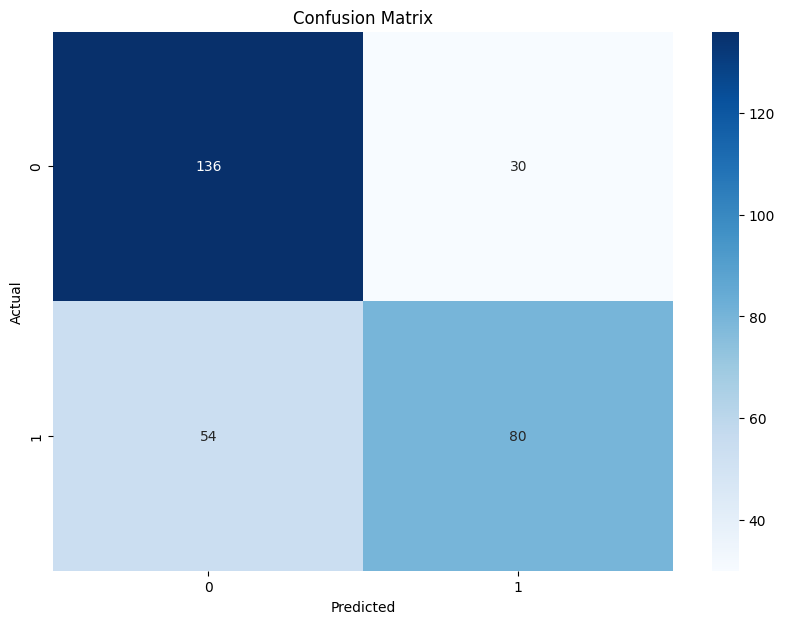

In [49]:
print("Accuracy:", accuracy_score(y_test.any(axis=1), toxic_pred))
print("Classification Report:\n", classification_report(y_test.any(axis=1), toxic_pred))

# 2. Curva ROC
fpr, tpr, _ = roc_curve(y_test.any(axis=1), toxic_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 3. Matriz de Confusión
conf_matrix = confusion_matrix(y_test.any(axis=1), toxic_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [50]:
y_train_pred, predictions = classifier.predict(X_train)

train_f1 = f1_score(y_train.any(axis=1), y_train_pred, average='macro')
print("Train F1-Score:", train_f1)


# Predecir en el conjunto de validación
y_val_pred, predictions = classifier.predict(X_test)

# Calcular el F1-Score en el conjunto de validación
val_f1 = f1_score(y_test.any(axis=1), y_val_pred, average='macro')
print("Validation F1-Score:", val_f1)


# Calcular la diferencia entre el F1-Score de entrenamiento y validación
overfitting_score = train_f1 - val_f1
print("Overfitting Score (Train F1 - Validation F1):", overfitting_score)

Train F1-Score: 0.8491516854398223
Validation F1-Score: 0.7098913243691287
Overfitting Score (Train F1 - Validation F1): 0.13926036107069362


In [52]:
texto_prueba = 'I hate black people'
processed_text = classifier.preprocess_text(texto_prueba)
processed_text = np.array([processed_text[0]])

is_toxic, toxicity_types = classifier.predict(processed_text)

# Mostrar resultados
print("¿Es tóxico?:", is_toxic[0])
print("Predicciones por tipo de toxicidad:")
for toxicity_type, prediction in toxicity_types.items():
    print(f"{toxicity_type}: {prediction[0]}")

¿Es tóxico?: True
Predicciones por tipo de toxicidad:
IsAbusive: 1
IsProvocative: 0


# Multihead con stacking logistico

In [53]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

class MultiHeadHateClassifier_2:
    def __init__(self):
        self.models_random_forest = {}
        self.models_xgboost = {}
        self.label_columns = ['IsAbusive', 'IsProvocative']
        self.embeddings_index = None
        # Add SMOTE for handling imbalanced data
        self.smote = SMOTE(random_state=42)
        # Add cross-validation
        self.cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    def optimize_random_forest_model(self, X, y, column):
        X_array = np.array(X)
        y_array = np.array(y[column])
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Increased range
                'max_depth': trial.suggest_int('max_depth', 5, 30),          # Increased range
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
                'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
                'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
            }
            
            scores = []
            for train_idx, val_idx in self.cv.split(X_array, y_array):
                X_train, X_val = X_array[train_idx], X_array[val_idx]
                y_train, y_val = y_array[train_idx], y_array[val_idx]
                
                # Apply SMOTE only on training data
                X_train_resampled, y_train_resampled = self.smote.fit_resample(X_train, y_train)
                
                model = RandomForestClassifier(**params)
                model.fit(X_train_resampled, y_train_resampled)
                y_pred = model.predict(X_val)
                scores.append(f1_score(y_val, y_pred))
            
            return np.mean(scores)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)  # Increased trials
        
        # Get best parameters and train final model
        best_params = study.best_params
        best_model = RandomForestClassifier(**best_params)
        X_resampled, y_resampled = self.smote.fit_resample(X_array, y_array)
        best_model.fit(X_resampled, y_resampled)
        return best_model
    
    def optimize_xgboost_model(self, X, y, column):
        X_array = np.array(X)
        y_array = np.array(y[column])
        pos_weight = (y_array == 0).sum() / (y_array == 1).sum()

        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
                'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'scale_pos_weight': pos_weight,
                'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
                'tree_method': 'hist'  # For faster training
            }
            
            scores = []
            for train_idx, val_idx in self.cv.split(X_array, y_array):
                X_train, X_val = X_array[train_idx], X_array[val_idx]
                y_train, y_val = y_array[train_idx], y_array[val_idx]
                
                X_train_resampled, y_train_resampled = self.smote.fit_resample(X_train, y_train)
                
                model = XGBClassifier(**params,  early_stopping_rounds=20)
                model.fit(
                    X_train_resampled, 
                    y_train_resampled,
                    eval_set=[(X_val, y_val)],
                    verbose=False
                )
                y_pred = model.predict(X_val)
                scores.append(f1_score(y_val, y_pred))
            
            return np.mean(scores)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=75)  # Increased trials
        
        best_params = study.best_params
        best_model = XGBClassifier(**best_params)
        X_resampled, y_resampled = self.smote.fit_resample(X_array, y_array)
        best_model.fit(X_resampled, y_resampled)
        return best_model

    def fit(self, X, y):
        X = np.array(X)
        
        for column in self.label_columns:
            print(f"Optimizing Random Forest model for {column}")
            best_randomforest_model = self.optimize_random_forest_model(X, y, column)
            self.models_random_forest[column] = best_randomforest_model
            
            print(f"Optimizing XGBoost model for {column}")
            best_xgboost_model = self.optimize_xgboost_model(X, y, column)
            self.models_xgboost[column] = best_xgboost_model
            
    def predict(self, X):
        # Ensure X is a numpy array
        X = np.array(X)
        
        predictions = {column: {
            'rf_prob': self.models_random_forest[column].predict_proba(X)[:, 1],
            'xgb_prob': self.models_xgboost[column].predict_proba(X)[:, 1]
        } for column in self.label_columns}
        
        final_predictions = []
        for column in self.label_columns:
            rf_weight = 0.4
            xgb_weight = 0.6
            
            combined_preds = (
                (rf_weight * predictions[column]['rf_prob']) + 
                (xgb_weight * predictions[column]['xgb_prob'])
            )
            final_predictions.append(combined_preds > 0.5)
        
        final_predictions = np.array(final_predictions).T
        return np.any(final_predictions, axis=1)
    
    def load_embeddings(self, file_path):
        # Load GloVe embeddings
        self.embeddings_index = {}
        with open(file_path, encoding='utf8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                self.embeddings_index[word] = coefs
                
    def preprocess_text(self, text):
        """Text preprocessing as defined in notebook"""
        tokens = procesar_texto(text) # Using existing function
        embedding = text_to_embedding(tokens, self.embeddings_index, 100)
        return np.array([embedding])

In [55]:
classifier = MultiHeadHateClassifier_2()
classifier.load_embeddings('../assets/glove.twitter.27B.100d.txt')

In [57]:
df = pd.read_csv('../database/toxic.csv')
threshold = 0.15

# Seleccionamos las columnas que queremos analizar (todas menos 'Text', 'CommentId', y 'VideoId')
columns_to_check = df.loc[:, ~df.columns.isin(['Text', 'CommentId', 'VideoId'])]

# Filtramos las columnas cuyo promedio sea mayor o igual al umbral
columns_above_threshold = columns_to_check.columns[columns_to_check.mean() >= threshold]

# Seleccionamos todas las columnas que queremos conservar
columns_to_keep = ['Text', 'CommentId', 'VideoId'] + list(columns_above_threshold)

# Filtramos el DataFrame con las columnas que cumplen con los criterios
df_filtered = df[columns_to_keep]

df_filtered = df_filtered.drop(columns = ['CommentId', 'VideoId'])

In [58]:
X = np.array([classifier.preprocess_text(text)[0] for text in df_filtered['Text']])
y = df_filtered[list(columns_above_threshold)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

In [59]:
classifier.fit(X_train, y_train)

[I 2024-11-19 13:45:50,313] A new study created in memory with name: no-name-7b958399-eac7-4473-a128-93c5696dd3cc


Optimizing Random Forest model for IsAbusive


[I 2024-11-19 13:45:56,442] Trial 0 finished with value: 0.5602080817274312 and parameters: {'n_estimators': 202, 'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 0 with value: 0.5602080817274312.
[I 2024-11-19 13:46:08,601] Trial 1 finished with value: 0.5555844880300995 and parameters: {'n_estimators': 292, 'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 0 with value: 0.5602080817274312.
[I 2024-11-19 13:46:15,978] Trial 2 finished with value: 0.5509011379749422 and parameters: {'n_estimators': 369, 'max_depth': 27, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini'}. Best is trial 0 with value: 0.5602080817274312.
[I

Optimizing XGBoost model for IsAbusive


[I 2024-11-19 13:59:33,257] Trial 0 finished with value: 0.5935013308308659 and parameters: {'n_estimators': 713, 'learning_rate': 0.23503644312037197, 'max_depth': 5, 'min_child_weight': 10, 'gamma': 1.3135559898318341e-06, 'subsample': 0.5747420790090999, 'colsample_bytree': 0.6561326392532254, 'reg_alpha': 5.770636871556241e-08, 'reg_lambda': 0.000716005861853509, 'max_delta_step': 4}. Best is trial 0 with value: 0.5935013308308659.
[I 2024-11-19 13:59:45,024] Trial 1 finished with value: 0.5294020391292367 and parameters: {'n_estimators': 215, 'learning_rate': 0.0002916653025559542, 'max_depth': 15, 'min_child_weight': 3, 'gamma': 4.425456254960358e-06, 'subsample': 0.7859579554247528, 'colsample_bytree': 0.9504845401757989, 'reg_alpha': 0.23050294031923887, 'reg_lambda': 1.022009847115191e-08, 'max_delta_step': 10}. Best is trial 0 with value: 0.5935013308308659.
[I 2024-11-19 14:00:16,818] Trial 2 finished with value: 0.567003163071487 and parameters: {'n_estimators': 385, 'learn

Optimizing Random Forest model for IsProvocative


[I 2024-11-19 14:09:45,156] Trial 0 finished with value: 0.30442904338500576 and parameters: {'n_estimators': 406, 'max_depth': 21, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 0 with value: 0.30442904338500576.
[I 2024-11-19 14:09:52,006] Trial 1 finished with value: 0.26501388606651766 and parameters: {'n_estimators': 287, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 0 with value: 0.30442904338500576.
[I 2024-11-19 14:10:16,444] Trial 2 finished with value: 0.22371466768525589 and parameters: {'n_estimators': 442, 'max_depth': 25, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 0 with value: 0.30442904338500576.
[I 2024-1

Optimizing XGBoost model for IsProvocative


[I 2024-11-19 15:38:49,746] Trial 0 finished with value: 0.2894407317910924 and parameters: {'n_estimators': 875, 'learning_rate': 0.0007340590157344347, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.003165615290175501, 'subsample': 0.8332591298116956, 'colsample_bytree': 0.8380521720365255, 'reg_alpha': 7.091511917467491, 'reg_lambda': 0.0008613689107961869, 'max_delta_step': 6}. Best is trial 0 with value: 0.2894407317910924.
[I 2024-11-19 15:38:53,023] Trial 1 finished with value: 0.2800878588199651 and parameters: {'n_estimators': 207, 'learning_rate': 0.0009204190940343305, 'max_depth': 6, 'min_child_weight': 13, 'gamma': 2.2203177229019608e-05, 'subsample': 0.993784761894358, 'colsample_bytree': 0.8607804842670365, 'reg_alpha': 5.318959989664094e-05, 'reg_lambda': 0.08224707966190123, 'max_delta_step': 10}. Best is trial 0 with value: 0.2894407317910924.
[I 2024-11-19 15:39:09,207] Trial 2 finished with value: 0.2800878588199651 and parameters: {'n_estimators': 817, 'learnin

Accuracy: 0.7266666666666667
Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.80      0.76       166
        True       0.72      0.64      0.68       134

    accuracy                           0.73       300
   macro avg       0.72      0.72      0.72       300
weighted avg       0.73      0.73      0.72       300



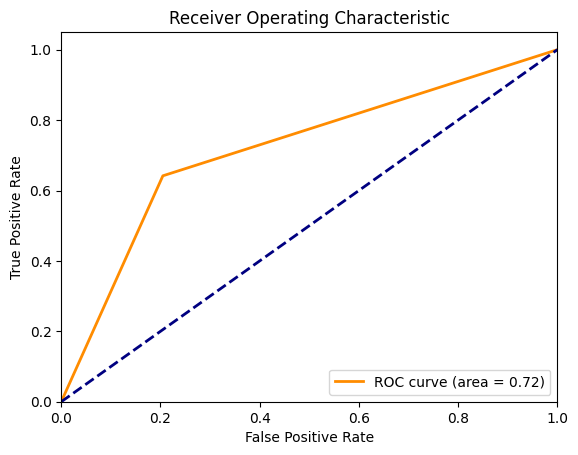

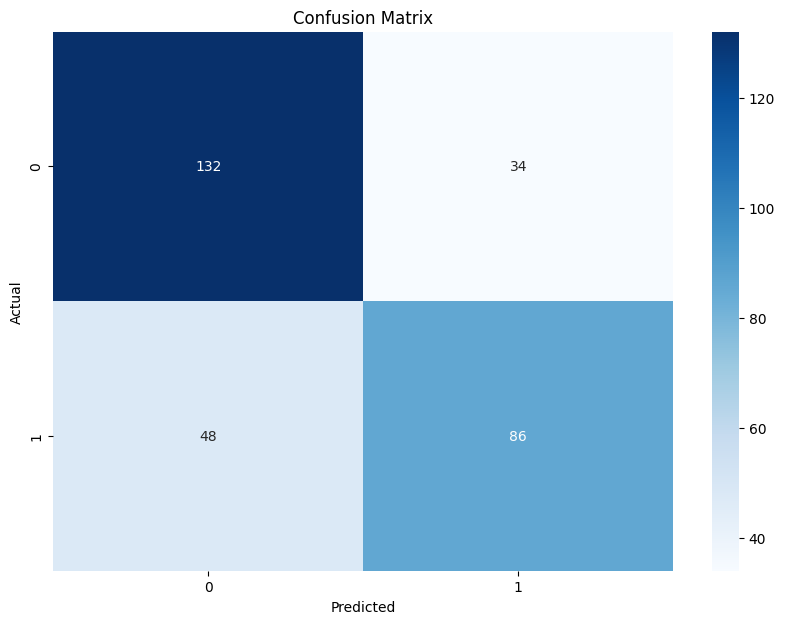

In [60]:
toxic_pred = classifier.predict(X_test)

# Mostrar resultados
print("Accuracy:", accuracy_score(y_test.any(axis=1), toxic_pred))
print("Classification Report:\n", classification_report(y_test.any(axis=1), toxic_pred))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test.any(axis=1), toxic_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test.any(axis=1), toxic_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [61]:
# Validación Cruzada
skf = StratifiedKFold(n_splits=5)
cross_val_scores = cross_val_score(classifier.models_xgboost['IsAbusive'], X, y['IsAbusive'], cv=skf, scoring='accuracy')
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", np.mean(cross_val_scores))

Cross-validation scores: [0.75  0.7   0.745 0.75  0.69 ]
Mean cross-validation score: 0.727


In [64]:
y_train_pred = classifier.predict(X_train)

# Calcular el F1-Score en el conjunto de entrenamiento
train_f1 = f1_score(y_train.any(axis=1), y_train_pred, average='macro')
print("Train F1-Score:", train_f1)

# Predecir en el conjunto de validación
y_val_pred = classifier.predict(X_test)

# Calcular el F1-Score en el conjunto de validación
val_f1 = f1_score(y_test.any(axis=1), y_val_pred, average='macro')
print("Validation F1-Score:", val_f1)

# Calcular la diferencia entre el F1-Score de entrenamiento y validación
overfitting_score = train_f1 - val_f1
print("Overfitting Score (Train F1 - Validation F1):", overfitting_score)

Train F1-Score: 0.8826005651944218
Validation F1-Score: 0.7200855673387647
Overfitting Score (Train F1 - Validation F1): 0.16251499785565704


In [65]:
import pickle

def guardar_modelo(modelo, nombre_archivo):
    """
    Guarda el modelo entrenado en un archivo .pkl

    Args:
    modelo: El modelo entrenado que se desea guardar.
    nombre_archivo: El nombre del archivo donde se guardará el modelo.
    """
    with open(nombre_archivo, 'wb') as archivo:
        pickle.dump(modelo, archivo)
    print(f"Modelo guardado en {nombre_archivo}")

guardar_modelo(classifier, 'Modelo multihead_glove.pkl')

Modelo guardado en Modelo multihead_glove.pkl


In [66]:
texto_prueba = 'I love black people'
processed_text = classifier.preprocess_text(texto_prueba)
processed_text = np.array([processed_text[0]])

is_toxic = classifier.predict(processed_text)

# Mostrar resultados
print("¿Es tóxico?:", is_toxic[0])

¿Es tóxico?: False


Versión usando BERT

In [ ]:
from transformers import BertTokenizer, BertModel
import torch


df = pd.read_csv('../database/toxic.csv')

ImportError: cannot import name 'SMOTE' from 'imblearn' (e:\Bootcamp\NLP_Grupo3\.venv\Lib\site-packages\imblearn\__init__.py)

In [14]:
class MultiHeadHateClassifier:
    def __init__(self):
        self.models_random_forest = {}
        self.models_xgboost = {}
        self.label_columns = ['IsAbusive', 'IsProvocative']
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.smote = SMOTE(random_state=42)
        self.cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    def optimize_random_forest_model(self, X, y, column):
        X_array = np.array(X)
        y_array = np.array(y[column])
        
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'max_depth': trial.suggest_int('max_depth', 5, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
                'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
                'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
            }
            
            scores = []
            for train_idx, val_idx in self.cv.split(X_array, y_array):
                X_train, X_val = X_array[train_idx], X_array[val_idx]
                y_train, y_val = y_array[train_idx], y_array[val_idx]
                
                X_train_resampled, y_train_resampled = self.smote.fit_resample(X_train, y_train)
                
                model = RandomForestClassifier(**params)
                model.fit(X_train_resampled, y_train_resampled)
                y_pred = model.predict(X_val)
                scores.append(f1_score(y_val, y_pred))
            
            return np.mean(scores)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)
        
        best_params = study.best_params
        best_model = RandomForestClassifier(**best_params)
        X_resampled, y_resampled = self.smote.fit_resample(X_array, y_array)
        best_model.fit(X_resampled, y_resampled)
        return best_model
    
    def optimize_xgboost_model(self, X, y, column):
        X_array = np.array(X)
        y_array = np.array(y[column])
        pos_weight = (y_array == 0).sum() / (y_array == 1).sum()

        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
                'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'scale_pos_weight': pos_weight,
                'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
                'tree_method': 'hist'
            }
            
            scores = []
            for train_idx, val_idx in self.cv.split(X_array, y_array):
                X_train, X_val = X_array[train_idx], X_array[val_idx]
                y_train, y_val = y_array[train_idx], y_array[val_idx]
                
                X_train_resampled, y_train_resampled = self.smote.fit_resample(X_train, y_train)
                
                model = XGBClassifier(**params, early_stopping_rounds=20)
                model.fit(
                    X_train_resampled, 
                    y_train_resampled,
                    eval_set=[(X_val, y_val)],
                    verbose=False
                )
                y_pred = model.predict(X_val)
                scores.append(f1_score(y_val, y_pred))
            
            return np.mean(scores)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)
        
        best_params = study.best_params
        best_model = XGBClassifier(**best_params)
        X_resampled, y_resampled = self.smote.fit_resample(X_array, y_array)
        best_model.fit(X_resampled, y_resampled)
        return best_model

    def fit(self, X, y):
        X = np.array(X)
        
        for column in self.label_columns:
            print(f"Optimizing Random Forest model for {column}")
            best_randomforest_model = self.optimize_random_forest_model(X, y, column)
            self.models_random_forest[column] = best_randomforest_model
            
            print(f"Optimizing XGBoost model for {column}")
            best_xgboost_model = self.optimize_xgboost_model(X, y, column)
            self.models_xgboost[column] = best_xgboost_model
            
    def predict(self, X):
        X = np.array(X)
        
        predictions = {column: {
            'rf_prob': self.models_random_forest[column].predict_proba(X)[:, 1],
            'xgb_prob': self.models_xgboost[column].predict_proba(X)[:, 1]
        } for column in self.label_columns}
        
        final_predictions = []
        for column in self.label_columns:
            rf_weight = 0.4
            xgb_weight = 0.6
            
            combined_preds = (
                (rf_weight * predictions[column]['rf_prob']) + 
                (xgb_weight * predictions[column]['xgb_prob'])
            )
            final_predictions.append(combined_preds > 0.5)
        
        final_predictions = np.array(final_predictions).T
        return np.any(final_predictions, axis=1), predictions

    def preprocess_text(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).numpy()
        return embedding

In [8]:
classifier = MultiHeadHateClassifier()

df = pd.read_csv('../database/toxic.csv')

# Definimos el umbral
threshold = 0.15

# Seleccionamos las columnas que queremos analizar (todas menos 'Text', 'CommentId', y 'VideoId')
columns_to_check = df.loc[:, ~df.columns.isin(['Text', 'CommentId', 'VideoId'])]

# Filtramos las columnas cuyo promedio sea mayor o igual al umbral
columns_above_threshold = columns_to_check.columns[columns_to_check.mean() >= threshold]

# Seleccionamos todas las columnas que queremos conservar
columns_to_keep = ['Text', 'CommentId', 'VideoId'] + list(columns_above_threshold)

# Filtramos el DataFrame con las columnas que cumplen con los criterios
df_filtered = df[columns_to_keep]

df_filtered = df_filtered.drop(columns = ['CommentId', 'VideoId'])

In [9]:
columns_above_threshold

Index(['IsToxic', 'IsAbusive', 'IsProvocative'], dtype='object')

In [10]:
X = np.array([classifier.preprocess_text(text)[0] for text in df_filtered['Text']])
y = df_filtered[list(columns_above_threshold)].drop(columns = 'IsToxic')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

In [15]:
classifier.fit(X_train, y_train)

[I 2024-11-19 18:54:17,055] A new study created in memory with name: no-name-adb250e0-8c5c-4004-9e6d-9c3e86c1226a


Optimizing Random Forest model for IsAbusive


[I 2024-11-19 19:06:59,501] Trial 0 finished with value: 0.46011511100704094 and parameters: {'n_estimators': 272, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 0 with value: 0.46011511100704094.
[I 2024-11-19 19:16:26,554] Trial 1 finished with value: 0.4637131677324248 and parameters: {'n_estimators': 261, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 1 with value: 0.4637131677324248.
[I 2024-11-19 19:16:31,207] Trial 2 finished with value: 0.598999276577216 and parameters: {'n_estimators': 196, 'max_depth': 17, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 2 with value: 0.598999276577216.
[I 2024-11-19 19:16:41,099] Trial 3 finishe

Optimizing XGBoost model for IsAbusive


[I 2024-11-19 20:32:46,677] Trial 0 finished with value: 0.6446942785511152 and parameters: {'n_estimators': 388, 'learning_rate': 0.003442846791460839, 'max_depth': 5, 'min_child_weight': 8, 'gamma': 1.3536166766383012e-07, 'subsample': 0.6972053159815061, 'colsample_bytree': 0.7349798020425204, 'reg_alpha': 0.0020422850729332983, 'reg_lambda': 0.055549263846678354, 'max_delta_step': 6}. Best is trial 0 with value: 0.6446942785511152.
[I 2024-11-19 20:32:50,093] Trial 1 finished with value: 0.6111850974021651 and parameters: {'n_estimators': 574, 'learning_rate': 0.20668313865763238, 'max_depth': 3, 'min_child_weight': 14, 'gamma': 0.054070686531268876, 'subsample': 0.7659041766972107, 'colsample_bytree': 0.5166647015556305, 'reg_alpha': 6.079134717552819e-07, 'reg_lambda': 9.607134060742948e-08, 'max_delta_step': 7}. Best is trial 0 with value: 0.6446942785511152.
[I 2024-11-19 20:33:39,225] Trial 2 finished with value: 0.5294020391292367 and parameters: {'n_estimators': 816, 'learni

Optimizing Random Forest model for IsProvocative


[I 2024-11-19 21:14:44,408] Trial 0 finished with value: 0.22464420111478933 and parameters: {'n_estimators': 118, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 0 with value: 0.22464420111478933.
[I 2024-11-19 21:18:33,224] Trial 1 finished with value: 0.34530377211527763 and parameters: {'n_estimators': 126, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 1 with value: 0.34530377211527763.
[I 2024-11-19 21:47:31,118] Trial 2 finished with value: 0.29944630582089904 and parameters: {'n_estimators': 344, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 1 with value: 0.34530377211527763.
[I 2024-11-19 21:47:45,4

Optimizing XGBoost model for IsProvocative


[I 2024-11-20 03:08:07,188] Trial 0 finished with value: 0.2800878588199651 and parameters: {'n_estimators': 658, 'learning_rate': 0.0006206475409008704, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 8.715299731942757e-05, 'subsample': 0.8319358232071783, 'colsample_bytree': 0.7565293704645204, 'reg_alpha': 1.2709441070126741e-06, 'reg_lambda': 1.280349795145504, 'max_delta_step': 0}. Best is trial 0 with value: 0.2800878588199651.
[I 2024-11-20 03:08:27,101] Trial 1 finished with value: 0.39132167461579226 and parameters: {'n_estimators': 832, 'learning_rate': 0.06659167977504961, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 0.005297476851555232, 'subsample': 0.7200782456646828, 'colsample_bytree': 0.5323516559984391, 'reg_alpha': 0.0037306111612899454, 'reg_lambda': 4.048749455532899, 'max_delta_step': 6}. Best is trial 1 with value: 0.39132167461579226.
[I 2024-11-20 03:08:35,775] Trial 2 finished with value: 0.37827341462900954 and parameters: {'n_estimators': 514, 'learning_r

Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.85      0.84       199
        True       0.68      0.64      0.66       101

    accuracy                           0.78       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.78      0.78      0.78       300



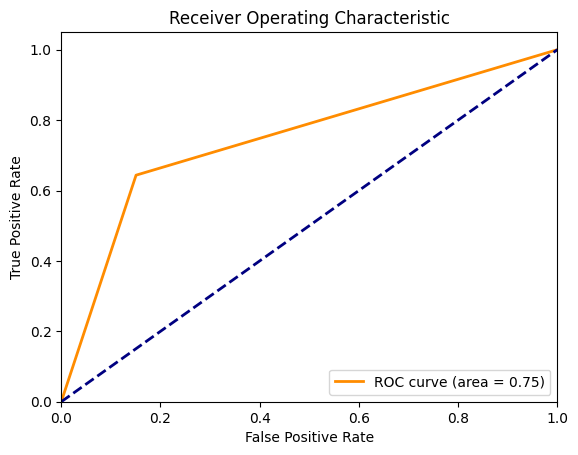

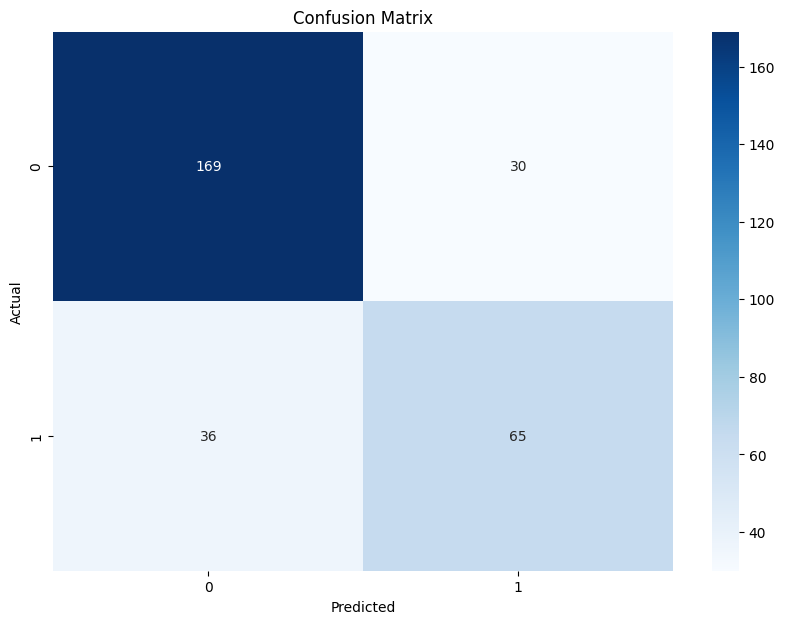

In [16]:
final_prediction, predictions = classifier.predict(X_test)

# Mostrar resultados
print("Accuracy:", accuracy_score(y_test.any(axis=1), final_prediction))
print("Classification Report:\n", classification_report(y_test.any(axis=1), final_prediction))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test.any(axis=1), final_prediction)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test.any(axis=1), final_prediction)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
skf = StratifiedKFold(n_splits=5)

# Diccionario para almacenar los puntajes de validación cruzada
cross_val_scores = {}

# Iterar sobre cada modelo en classifier.models
for label in classifier.label_columns:
    model = classifier.models[label]
    scores = cross_val_score(model, X, y[label], cv=skf, scoring='accuracy')
    cross_val_scores[label] = scores
    print(f"Cross-validation scores for {label}: {scores}")
    print(f"Mean cross-validation score for {label}: {np.mean(scores)}")

# Mostrar los puntajes de validación cruzada para todos los modelos
print("Cross-validation scores for all models:", cross_val_scores)

AttributeError: 'MultiHeadHateClassifier' object has no attribute 'models'

In [23]:
def predict_text(classifier, text):
    processed_text = classifier.preprocess_text(text)
    
    # Hacer la predicción
    final_prediction, predictions = classifier.predict(processed_text)
    
    # Mostrar las predicciones
    print("Final Prediction (any label):", final_prediction)
    for label, prediction in predictions.items():
        print(f"Prediction for {label}: {prediction}")
    
    return predictions

In [28]:
text = "I love Donald Trump"
predictions = predict_text(classifier, text)

Final Prediction (any label): [False]
Prediction for IsAbusive: [0]
Prediction for IsProvocative: [0]
Prediction for IsHatespeech: [0]
Prediction for IsRacist: [0]


In [22]:
import joblib

class MultiHeadHateClassifier:
    def __init__(self):
        self.models_random_forest = {}
        self.models_xgboost = {}
        self.label_columns = ['IsAbusive', 'IsProvocative']
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.smote = SMOTE(random_state=42)
        self.cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    def optimize_random_forest_model(self, X, y, column):
        X_array = np.array(X)
        y_array = np.array(y[column])
        
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'max_depth': trial.suggest_int('max_depth', 5, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
                'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
                'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
            }
            
            scores = []
            for train_idx, val_idx in self.cv.split(X_array, y_array):
                X_train, X_val = X_array[train_idx], X_array[val_idx]
                y_train, y_val = y_array[train_idx], y_array[val_idx]
                
                X_train_resampled, y_train_resampled = self.smote.fit_resample(X_train, y_train)
                
                model = RandomForestClassifier(**params)
                model.fit(X_train_resampled, y_train_resampled)
                y_pred = model.predict(X_val)
                scores.append(f1_score(y_val, y_pred))
            
            return np.mean(scores)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)
        
        best_params = study.best_params
        best_model = RandomForestClassifier(**best_params)
        X_resampled, y_resampled = self.smote.fit_resample(X_array, y_array)
        best_model.fit(X_resampled, y_resampled)
        return best_model
    
    def optimize_xgboost_model(self, X, y, column):
        X_array = np.array(X)
        y_array = np.array(y[column])
        pos_weight = (y_array == 0).sum() / (y_array == 1).sum()

        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
                'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'scale_pos_weight': pos_weight,
                'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
                'tree_method': 'hist'
            }
            
            scores = []
            for train_idx, val_idx in self.cv.split(X_array, y_array):
                X_train, X_val = X_array[train_idx], X_array[val_idx]
                y_train, y_val = y_array[train_idx], y_array[val_idx]
                
                X_train_resampled, y_train_resampled = self.smote.fit_resample(X_train, y_train)
                
                model = XGBClassifier(**params, early_stopping_rounds=20)
                model.fit(
                    X_train_resampled, 
                    y_train_resampled,
                    eval_set=[(X_val, y_val)],
                    verbose=False
                )
                y_pred = model.predict(X_val)
                scores.append(f1_score(y_val, y_pred))
            
            return np.mean(scores)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)
        
        best_params = study.best_params
        best_model = XGBClassifier(**best_params)
        X_resampled, y_resampled = self.smote.fit_resample(X_array, y_array)
        best_model.fit(X_resampled, y_resampled)
        return best_model

    def fit(self, X, y):
        X = np.array(X)
        
        for column in self.label_columns:
            print(f"Optimizing Random Forest model for {column}")
            best_randomforest_model = self.optimize_random_forest_model(X, y, column)
            self.models_random_forest[column] = best_randomforest_model
            
            print(f"Optimizing XGBoost model for {column}")
            best_xgboost_model = self.optimize_xgboost_model(X, y, column)
            self.models_xgboost[column] = best_xgboost_model
            
    def predict(self, X):
        X = np.array(X)
        
        predictions = {column: {
            'rf_prob': self.models_random_forest[column].predict_proba(X)[:, 1],
            'xgb_prob': self.models_xgboost[column].predict_proba(X)[:, 1]
        } for column in self.label_columns}
        
        final_predictions = []
        for column in self.label_columns:
            rf_weight = 0.4
            xgb_weight = 0.6
            
            combined_preds = (
                (rf_weight * predictions[column]['rf_prob']) + 
                (xgb_weight * predictions[column]['xgb_prob'])
            )
            final_predictions.append(combined_preds > 0.5)
        
        final_predictions = np.array(final_predictions).T
        return np.any(final_predictions, axis=1), predictions

    def preprocess_text(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).numpy()
        return embedding
    
classifier = MultiHeadHateClassifier()

joblib.dump(classifier, '../models/stack_model_BERT.pkl')

['../models/stack_model_BERT.pkl']